# 0. Data preprocessing

In [1]:
import xarray as xr
import pandas as pd
import dask


file_path = './wind/20170901_UV.nc'

# Load the netCDF file
try:
    ds_raw_uv = xr.open_dataset(file_path)
except FileNotFoundError:
    error_message = "File not found. Please upload the file '20170901_UV.nc' to proceed."
    ds_raw_uv = None
if ds_raw_uv:
    df_raw_uv = ds_raw_uv.to_dataframe()
    csv_file_path = './wind/20170901_UV.csv'
    df_raw_uv.to_csv(csv_file_path)
    success_message = f"File converted to CSV and saved as '{csv_file_path}'."
else:
    success_message = ""

success_message

"File converted to CSV and saved as './wind/20170901_UV.csv'."

In [2]:
# informatino of ds
ds_raw_uv

<xarray.Dataset>
Dimensions:                (latitude: 855, longitude: 1215, time: 24)
Coordinates:
  * latitude               (latitude) float64 -5.609 -5.557 ... 36.03 36.07
  * longitude              (longitude) float64 20.39 20.44 20.49 ... 83.37 83.42
  * time                   (time) datetime64[ns] 2017-09-01 ... 2017-09-01T23...
Data variables: (12/34)
    UGRD_10maboveground    (time, latitude, longitude) float32 -0.53 ... 2.87
    VGRD_10maboveground    (time, latitude, longitude) float32 -2.5 ... -0.47
    UGRD_20maboveground    (time, latitude, longitude) float32 -0.78 ... 2.92
    VGRD_20maboveground    (time, latitude, longitude) float32 -3.98 ... -0.47
    UGRD_30maboveground    (time, latitude, longitude) float32 -1.03 ... 2.99
    VGRD_30maboveground    (time, latitude, longitude) float32 -5.62 ... -0.5
    ...                     ...
    UGRD_800maboveground   (time, latitude, longitude) float32 1.02 1.12 ... 8.0
    VGRD_800maboveground   (time, latitude, longitude) float32 -4.43 ... 0.02
    UGRD_900maboveground   (time, latitude, longitude) float32 1.01 ... 9.17
    VGRD_900maboveground   (time, latitude, longitude) float32 -3.46 ... -1.16
    UGRD_1000maboveground  (time, latitude, longitude) float32 0.88 1.0 ... 9.55
    VGRD_1000maboveground  (time, latitude, longitude) float32 -2.4 ... -1.75
Attributes:
    Conventions:          COARDS
    History:              created by wgrib2
    GRIB2_grid_template:  10

In [3]:
# Then, let's read the csv file fist and then transform it as numpy
import pandas as pd
import numpy as np

file_path = './wind/20170901_UV.csv'  # Replace with your CSV file path
df = pd.read_csv(file_path, engine='pyarrow') # to speed up the reading 
_data_array_raw_uv = df.to_numpy()

transform the nc file into csv file

In [4]:
# to calcuate the norm of wind speed at the first time lag for each locations
# (0, 1) is (Lat, Lon), and (3, 4) is the (u, v)
data_array_raw_uv = _data_array_raw_uv[::24, :][:, (0, 1, 3, 4)]
data_float_raw_uv = data_array_raw_uv.astype(float)
np.savetxt("./wind/20170901_UV_1038825.csv", data_float_raw_uv, delimiter=",")
data_float_raw_uv.shape

(1038825, 4)

In [5]:
# Check for NaN values
nan_mask = np.isnan(data_float_raw_uv)
np.any(nan_mask)

False

In [6]:
# (u^2 + v^2)^(0.5)
_speed = np.sqrt(data_float_raw_uv[:, 2] ** 2 + data_float_raw_uv[:, 3] ** 2)
_speed = np.array(_speed).reshape(-1, 1)
# we would like to have the sqaure root of speed,
# because the skewness will be removed from the 
# residules if speed -> sqrt(speed)
_speed_squareroot = np.sqrt(_speed)
print("Speed: ", _speed[:5])
print("Root sqaure of speed: ", _speed_squareroot[:5])

Speed:  [[2.55556256]
 [2.70667693]
 [2.75007273]
 [3.17238081]
 [3.34755134]]
Root sqaure of speed:  [[1.5986127 ]
 [1.64519814]
 [1.65833432]
 [1.78111785]
 [1.82963148]]


In [10]:
_data_with_speed_squareroot = np.concatenate((data_float_raw_uv, _speed_squareroot), axis=1)
_data_with_speed_squareroot[:5]

array([[-5.60916500e+00,  2.03896680e+01, -5.30000000e-01,
        -2.50000000e+00,  1.59861270e+00],
       [-5.60916500e+00,  2.04415885e+01, -3.00000000e-01,
        -2.69000000e+00,  1.64519814e+00],
       [-5.60916500e+00,  2.04935090e+01,  2.00000000e-02,
        -2.75000000e+00,  1.65833432e+00],
       [-5.60916500e+00,  2.05454295e+01,  2.80000000e-01,
        -3.16000000e+00,  1.78111785e+00],
       [-5.60916500e+00,  2.05973500e+01,  5.00000000e-01,
        -3.31000000e+00,  1.82963148e+00]])

In [8]:
data_speed_squareroot = _data_with_speed_squareroot[:, [0, 1, 4]]
data_speed_squareroot

array([[-5.609165  , 20.389668  ,  1.5986127 ],
       [-5.609165  , 20.44158849,  1.64519814],
       [-5.609165  , 20.49350898,  1.65833432],
       ...,
       [36.07181913, 83.31730296,  1.68260161],
       [36.07181913, 83.36922345,  1.67319198],
       [36.07181913, 83.42114394,  1.66873913]])

In [9]:
np.savetxt("./wind/20170901_speed_1038825.csv", data_speed_squareroot, delimiter=",")
data_speed_squareroot.shape

(1038825, 3)

# 1. Data mean removal

In [11]:
import pandas as pd
import statsmodels.api as sm
from scipy import stats

# Load your data
df_speed_squareroot = pd.read_csv('./wind/20170901_speed_1038825.csv',  header=None, names=['Lat', 'Lon', 'Speed']) 

# Define predictors and dependent variable
X = df_speed_squareroot[['Lat','Lon']] 
y = df_speed_squareroot['Speed'] 

# Add a constant to the model (if using statsmodels)
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Predict values
predictions = model.predict(X)

# Remove the mean function
residuals = y - predictions

# Check if the residuals are normally distributed
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test: {shapiro_test}")

Shapiro-Wilk Test: ShapiroResult(statistic=0.9970930814743042, pvalue=0.0)


/home/panq/miniconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### The mean function parameter

In [12]:
model.params

const    1.946045
Lat     -0.003721
Lon      0.003401
dtype: float64

# 2. Observation plot (Square root)

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

np.random.seed(42)

def process_and_split_data(meta_file, observation_file, train_num, test_num):
    """
    Process the datasets and split them into training and testing subsets separately for meta and observation data.

    :param meta_file: File path for the METAinfo dataset.
    :param observation_file: File path for the ppt.complete.Y001 dataset.
    :param train_num: Percentage of the data to be used for training (default 10%).
    :param test_num: Percentage of the data to be used for testing (default 1%).
    :return: None
    """
    # Read the datasets without headers
    meta_data = pd.read_csv(meta_file, header=None)
    observation_data = pd.read_csv(observation_file, header=None)
    
    # Assuming meta_data and observation_data are of the same length
    n_rows = len(meta_data)

    # Generate random indices
    all_indices = np.arange(n_rows)
    train_and_test_indices = np.random.choice(all_indices, size=train_num + test_num, replace=False)

    # Split indices into training and testing
    train_indices, test_indices = train_test_split(train_and_test_indices, test_size=test_num / (train_num + test_num), random_state=42)

    # Sample data using the same indices for both datasets
    meta_train = meta_data.iloc[train_indices]
    meta_test = meta_data.iloc[test_indices]
    observation_train = observation_data.iloc[train_indices]
    observation_test = observation_data.iloc[test_indices]

    # Save the split data
    meta_train.to_csv(
        os.path.join(data_folder, 'meta_train_' + str(train_num)), 
        index=False, header=False)
    print(meta_train.shape)
    meta_test.to_csv(
        os.path.join(data_folder, 'meta_test_' + str(train_num)), 
        index=False, header=False)
    print(meta_test.shape)
    observation_train.to_csv(
        os.path.join(data_folder, 'observation_train_' + str(train_num)), 
        index=False, header=False)
    observation_test.to_csv(
        os.path.join(data_folder, 'observation_test_'+ str(train_num)), 
        index=False, header=False)

    print("Data processing complete. Files saved for both meta and observation datasets.")

data_folder = './wind/'
# Example usage
process_and_split_data(
    os.path.join(data_folder, 'METAinfo'), 
    os.path.join(data_folder,'observations'),
    250*1000, 25*1000
)
# Example usage
process_and_split_data(
    os.path.join(data_folder, 'METAinfo'), 
    os.path.join(data_folder,'observations'),
    500*1000, 50*1000
)

(250000, 2)
(25000, 2)
Data processing complete. Files saved for both meta and observation datasets.
(500000, 2)
(50000, 2)
Data processing complete. Files saved for both meta and observation datasets.


In [15]:
import pandas as pd
data_folder = './wind/'
df_observation_test_250000 = pd.read_csv(os.path.join(data_folder,'observation_test_250000'), header=None, names=['z'])
df_observation_test_250000.var()

z    0.356759
dtype: float64

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['font.size'] = 18  # You can set any numeric value here

def plot_subplots_with_scatter(train_meta_file, train_obs_file, test_meta_file, test_obs_file):
    # Load the data
    train_meta = pd.read_csv(train_meta_file, header=None)
    train_obs = pd.read_csv(train_obs_file, header=None)
    test_meta = pd.read_csv(test_meta_file, header=None)
    test_obs = pd.read_csv(test_obs_file, header=None)
    
    # Convert data to numpy arrays if they're not already
    all_train_data = np.array(train_meta)
    all_train_obs = np.array(train_obs).flatten()  # Flatten in case the observations are in a 2D array
    all_test_data = np.array(test_meta)
    all_test_obs = np.array(test_obs).flatten()
    
    # Create subplots
    fig, axs = plt.subplots(1, 1, figsize=(8, 4))
    
    # Scatter plot for training data
    scatter_train = axs.scatter(all_train_data[:, 1], all_train_data[:, 0], c=all_train_obs, 
                            #  vmin=np.min(all_train_obs), vmax=np.max(all_train_obs), 
                             cmap="jet", s=3)
    # Create a colorbar
    cbar = fig.colorbar(scatter_train, ax=axs)
    # cbar.ax.tick_params(labelsize =14)
    
    # axs.set_title('Training Data')
    axs.set_xlabel('Longitude')
    axs.set_ylabel('Latitude')
    
    # tick modification
    plt.tick_params(axis='both', which='major')
    
    plt.tight_layout()
    plt.savefig('./fig/realdataset/wind_subsampling.jpeg', dpi=100)
    plt.show()

# Example usage
# plot_subplots_with_scatter('meta_train.csv', 'observation_train.csv', 'meta_test.csv', 'observation_test.csv')

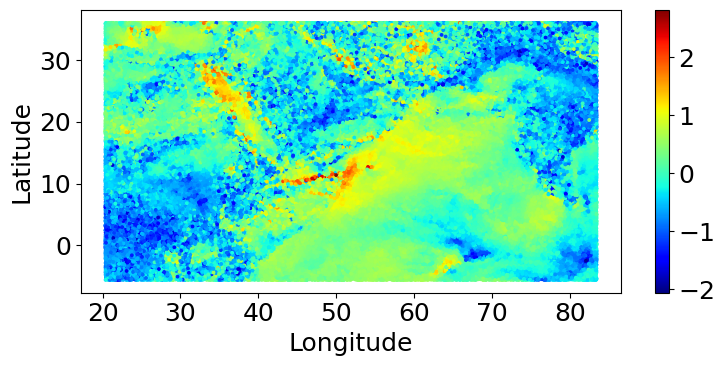

In [17]:
plot_subplots_with_scatter(
    './wind/meta_train_250000', 
    './wind/observation_train_250000',
    './wind/meta_test_250000', 
    './wind/observation_test_250000'   
)

##### Raw data plot

In [19]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# def plot_subplots_with_scatter(xx, yy, z):
    
#     # Convert data to numpy arrays if they're not already
#     xx = np.array(xx)
#     yy = np.array(yy)
#     z = np.array(z)
    
#     # Create subplots
#     fig, axs = plt.subplots(1, 1, figsize=(8, 4))
    
#     # Scatter plot for training data
#     scatter_train = axs.scatter(yy, xx, c=z, 
#                             #  vmin=np.min(all_train_obs), vmax=np.max(all_train_obs), 
#                              cmap="jet", s=3)
#     # Create a colorbar
#     cbar = fig.colorbar(scatter_train, ax=axs)
#     cbar.ax.tick_params(labelsize =14)
    
#     # axs.set_title('Training Data')
#     axs.set_xlabel('Longitude')
#     axs.set_ylabel('Latitude')
    
#     # tick modification
#     plt.tick_params(axis='both', which='major')
    
#     plt.tight_layout()
#     plt.savefig('./fig/realdataset/wind_rawdata.jpeg', dpi=100)
#     plt.show()

# df_speed = pd.read_csv('./wind/20170901_speed_1038825.csv', header = None)
# plot_subplots_with_scatter(df_speed.iloc[:, 0], df_speed.iloc[:, 1], df_speed.iloc[:, 2])

# 3. Plot the results (after running experiments)

In [20]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import csv

data_path = './log/wind'
plt.rcParams['font.size'] = 18  # You can set any numeric value here

def read_results(locs_set, cs_set, ordering='random'):
    results = {
        "cs_num":[],
        "Iterations":[],
        "Variance":[],
        "Range": [],
        "Smoothness": [],
        "Nugget": [],
        "log-likelihood":[]
    }

    for _los_num in locs_set:
        for _cs_num in cs_set:
            if ordering == 'random':
                filename = f'locs_{_los_num}_cs_{_cs_num}_random'
            else:
                filename = f'locs_{_los_num}_cs_{_cs_num}_morton'
            with open(os.path.join(data_path, filename), 'r') as file:
                reader = csv.reader(file)
                # Skip the first line (header)
                next(reader)
                # Read the second line
                second_line = next(reader)
            results["cs_num"].append(_cs_num) # iteration
            results["Iterations"].append(int(second_line[0])) # iteration
            results["Variance"].append(float(second_line[1])) # iteration
            results["Range"].append(float(second_line[2]) * 2523.64) # iteration
            results["Smoothness"].append(float(second_line[3])) # iteration
            results["Nugget"].append(float(second_line[4])) # iteration
            results["log-likelihood"].append(float(second_line[5])) # iteration
    return results

results_250k_random = read_results([250000], [10, 30, 60, 90, 120, 150], 'random')
# results_500k_random = read_results([500000], [10, 30, 60, 90, 120], 'random')
# results_250k_morton = read_results([250000], [10, 30, 60, 90, 120, 150], 'morton')
# results_500k_morton = read_results([500000], [10, 30, 60, 90, 120], 'morton')

def plot_params(results, param_name, ylabel, fig_path, problem_size, results_ylim):
    plt.figure(figsize=(5, 4))
    results_random, results_morton = results
    
    plt.plot(results_random['cs_num'], results_random[param_name], 
             linewidth=1.5, marker="s", label='Vecchia-random')
    # plt.plot(results_morton['cs_num'], results_morton[param_name], 
    #          linewidth=1.5, marker="s", label='Morton')
    if (problem_size == 2500000):
        if (param_name == 'Iterations'):
            plt.axhline(y=189, color='r',  linewidth=1.5, 
                        label='ExaGeoStat', linestyle='-.')
        elif (param_name == 'Variance'):
            plt.axhline(y=0.27074957, color='r',  linewidth=1.5, 
                        label='ExaGeoStat', linestyle='-.')
            # plt.ylim(4.75, 5.25)
        elif (param_name == 'Range'):
            plt.axhline(y=0.02251723 * 2523.64, color='r',  linewidth=1.5, 
                        label='ExaGeoStat', linestyle='-.')
            # plt.ylim(47, 65)
        elif (param_name == 'Smoothness'):
            # pass
            plt.axhline(y=1.02090214, color='r',  linewidth=1.5, 
                        label='ExaGeoStat', linestyle='-.')
            # plt.ylim(1.10, 1.20)
        elif (param_name == 'Nugget'):
            # pass
            plt.axhline(y=0.00100000, color='r',  linewidth=1.5, 
                        label='ExaGeoStat', linestyle='-.')
            plt.ylim(0.0008, 0.0012)
        elif (param_name == 'log-likelihood'):
            pass
            # plt.axhline(y=-295218.889836988761089742/10000, color='r',  linewidth=1.5, 
            #             label='ExaGeoStat', linestyle='-.')
    
    legend = plt.legend()
    legend.get_frame().set_alpha(0.01)  # 50% transparency
    plt.xlabel("Conditioning size")
    # plt.ylabel(ylabel)
    # plt.ylim(np.min([np.min([results[0][param_name], results[1][param_name]]), 
    #                  np.min([results_ylim[0][param_name], results_ylim[1][param_name]])])*0.97, 
    #         np.max([np.max([results[0][param_name], results[1][param_name]]), 
    #                 np.max([results_ylim[0][param_name], results_ylim[1][param_name]])])*1.03)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(results[0]['cs_num'], results[0]['cs_num'])
    plt.tight_layout()
    plt.savefig(os.path.join(fig_path, str(problem_size) + "_" + param_name + ".pdf"))
    plt.show()

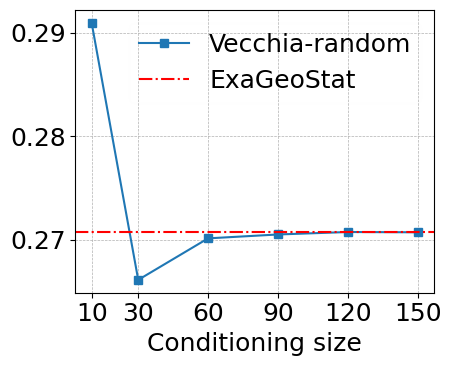

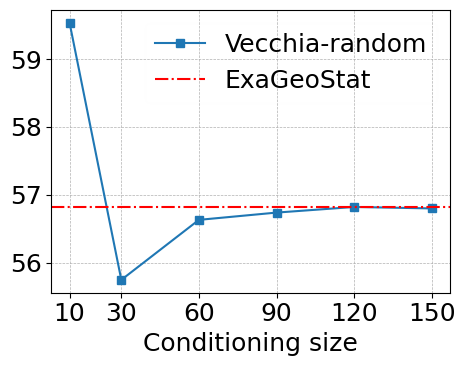

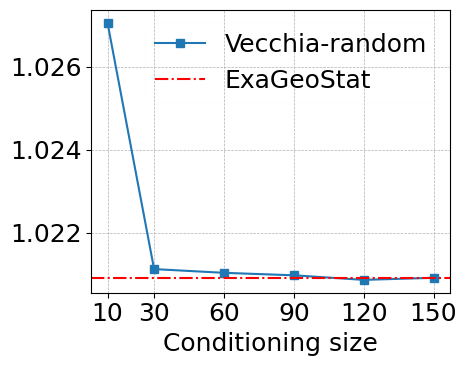

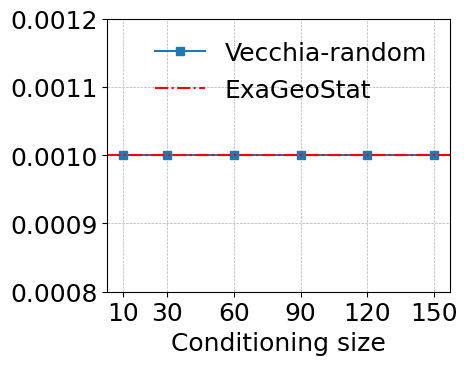

In [21]:
param_names= list(results_250k_random.keys())[2:-1]
ylabel_names = ["Iterations", r"$\hat\sigma^2$",  r"$\hat \beta$", r"$\hat \alpha$", r"$\hat \sigma^2_0$", 'Log-likelihood'] 

figpath = './fig/wind_results'
if not os.path.exists(figpath):
    os.mkdir(figpath)

for _param_name, _ylabel_name in zip(param_names, ylabel_names):
    plot_params(results=[results_250k_random, []], 
                param_name = _param_name, 
                ylabel=_ylabel_name, fig_path=figpath, 
                problem_size=2500000,
                results_ylim = [[], []])

In [1]:
# if not os.path.exists(figpath):
#     os.mkdir(figpath)

# for _param_name, _ylabel_name in zip(param_names, ylabel_names):
#     plot_params(results=[results_500k_random, results_500k_morton], 
#                 param_name = _param_name, 
#                 ylabel=_ylabel_name, fig_path=figpath, 
#                 problem_size=5000000,
#                 results_ylim = [results_250k_random, results_250k_morton])